<h1  style="color:white; background-color: #154360; padding:30px;"> 
Résultats numériques pour l'algorithme Deep Optimal Stopping </h1>

In [1]:
import sys
import helper_plots


sys.path.append("..")


import numpy as np


import src.tools.diffusion.black_scholes as bs

import src.main.dynamic_programming.dos_pricer as dos_pricer


import src.tools.option.option_main_class as option


from torch import nn
from tqdm import tqdm


import matplotlib.pyplot as plt
import pandas as pd

import torch

Dans ce notebook, je présente l'implémentation de l'algorithme Deep Optimal Stopping (voir [Deep Optimal Stopping](http://arxiv.org/abs/1804.05394)).

## Sanity Check 

Je teste ici si je retrouve bien les bonnes valeurs pour un put américain. Pour commencer
je prend 1000 scénarios Monte-Carlo pour l'entrainement et je fais varier le nombre de 
scénarios pour l'inférence. Je prend le **learning rate à $0.001$** ,le **nombre d'
épochs à $100$** et le **nombre de pas de simulation** à $10$, un learning rate plus bas et un nombre plus grand d'epochs est beaucoup
plus coûteux. 

In [2]:
N_training = int(1e5)
n = 50
learning_rate = 1e-2
batch_size = 5000
epochs = 20
strike = 40
rate = 0.06
maturity = 1

put_payoff = lambda x : np.maximum(strike - np.squeeze(x[:,0]),0)
o = option.Option(1, 40, 0.06, put_payoff)

asset = [bs.BlackScholes(36, 0.06, 0.4) for _ in range(1)]

list_weights = [40,30]
activation_function = nn.ReLU()

In [4]:
pricer_dos = dos_pricer.PricerDeepOptimalStopping(
    o, asset, list_weights, learning_rate, batch_size, activation_function, epochs
)

In [5]:
price_training,ci,cd,_,stopping_times = pricer_dos.price(n,N_training,disable=False)

100%|██████████| 48/48 [02:14<00:00,  2.80s/it]


In [6]:
print(f"Price on training set is {price_training,ci,cd}")

Price on training set is (7.115224514808178, 7.154144209347263, 7.076304820269093)


Text(0.5, 1.0, 'Fonction de coût pour les 9 réseaux de neurones entrainés')

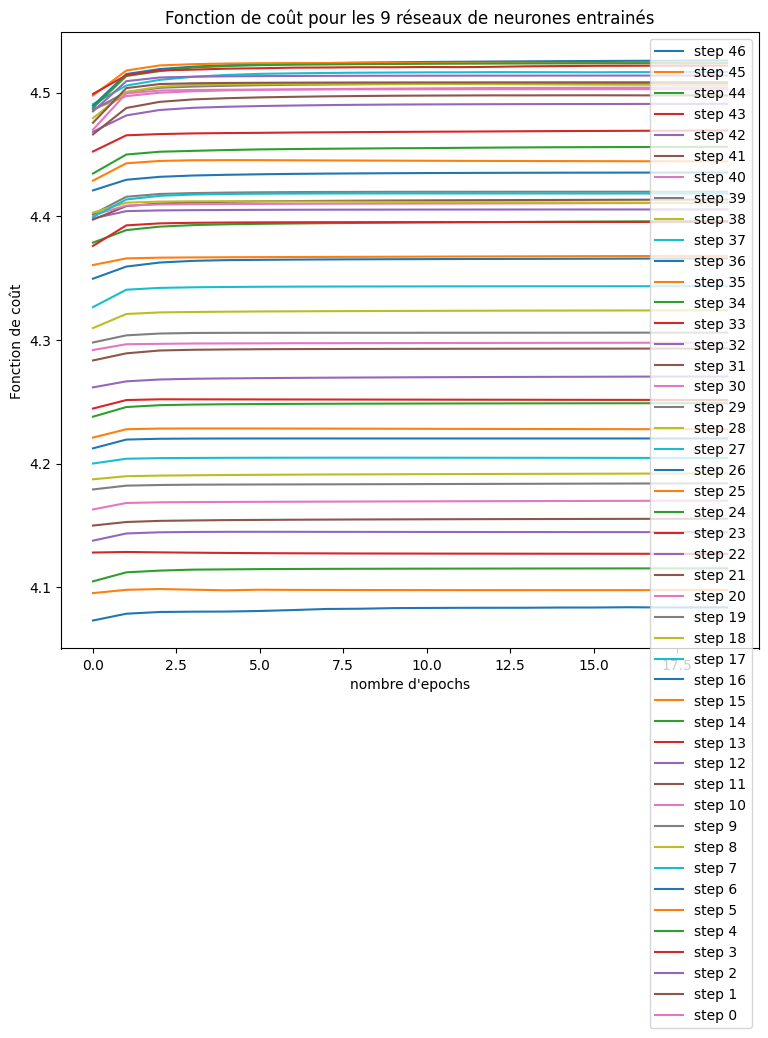

In [13]:
plt.figure(figsize=(9, 8))

history = pricer_dos.intermediate_values["loss"]
for epoch in range(1,len(history)):
    plt.plot(history[epoch],label=f"step {len(history)-1-epoch}")

plt.xlabel("nombre d'epochs")
plt.ylabel("Fonction de coût")
plt.legend()
plt.title("Fonction de coût pour les 9 réseaux de neurones entrainés")


**Remarque** : L'évolution de la fonction de coût devient instable ce qui indique le 
learning rate est trop élévé.

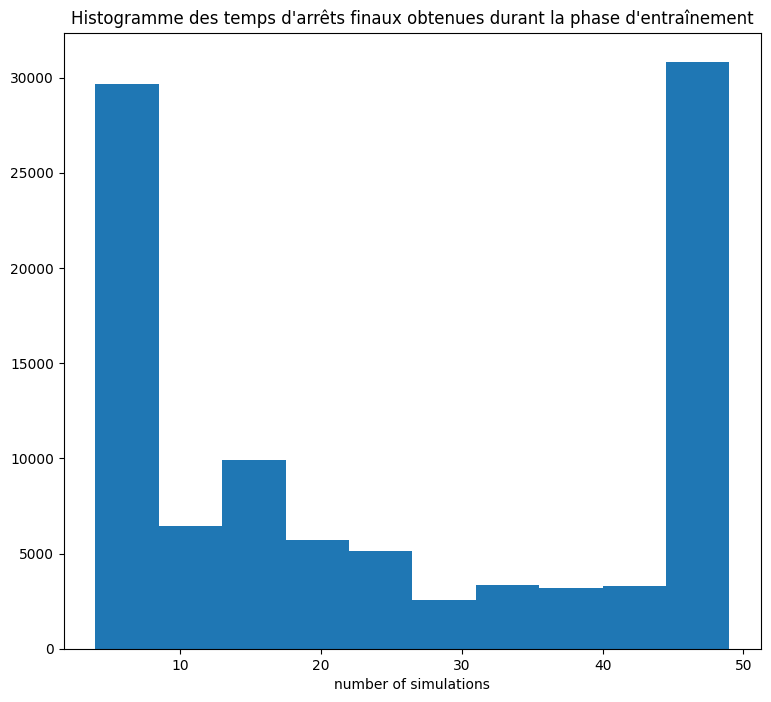

In [14]:
plt.figure(figsize=(9, 8))
plt.hist(stopping_times, bins=10, histtype="barstacked")
plt.xlabel("number of simulations")
plt.title(
    "Histogramme des temps d'arrêts finaux obtenues durant la phase d'entraînement"
)
plt.show()

In [3]:
list_simulation = [i for i in range(1000, 100000, 10000)]
tirage = 20

list_number_simulations = [N for N in range(1000, 100000, 10000)]
list_put_price = np.zeros((tirage, 10))
list_time = np.zeros((tirage, 10))

for idx, n_simulation in tqdm(enumerate(range(1000, 100000, 10000))):
    for m in range(tirage):
        price, _,_,t,_= pricer_dos.test(50,n_simulation)
        list_put_price[m, idx] = price
        list_time[m, idx] = t

0it [00:00, ?it/s]


NameError: name 'pricer_dos' is not defined

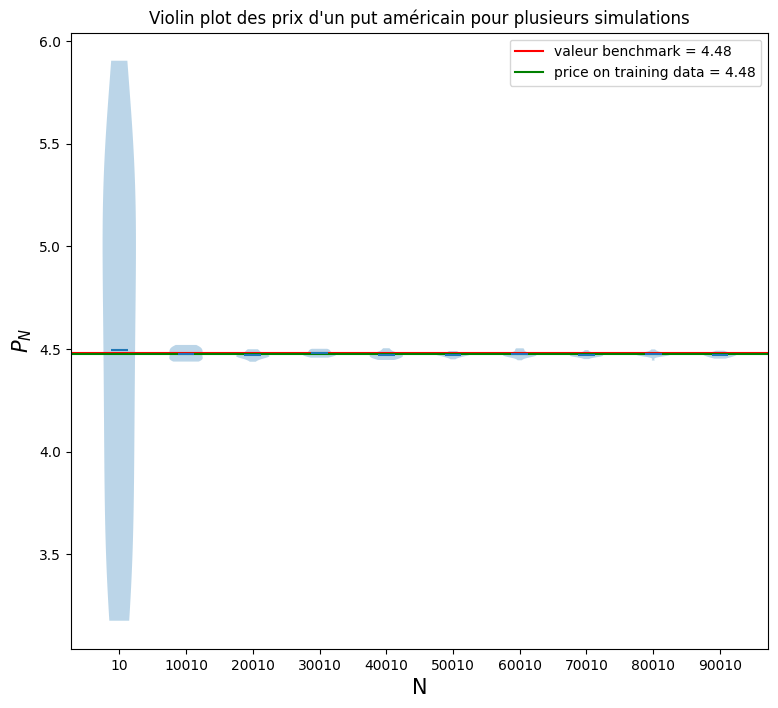

In [18]:
helper_plots.violin_plot(
    list_put_price,
    list_number_simulations,
    4.48,
    "Violin plot des prix d'un put américain pour plusieurs simulations",
    price_training
)

### Test pour un maxcall en dimension 2

In [7]:
def call_payoff(x):
    d = x.shape[1]
    max_mat = np.zeros((x.shape[0], d))
    for i in range(d):
        max_mat[:, i] = np.maximum(x[:, i] - strike, 0)
    return np.max(max_mat, axis=1)

In [13]:
d = 2
N_training = int(1e5)
n = 10
learning_rate = 1e-2
batch_size = 10000
epochs = 10
strike = 100
spot = 110
rate = 0.05
vol = 0.2
dividend = 0.10
maturity = 3

o = option.Option(maturity, strike, rate, call_payoff)

asset = [bs.BlackScholes(spot, rate, vol, dividend) for _ in range(d)]

list_weights = [20+d, 20+d]
activation_function = nn.ReLU()

In [14]:
pricer_dos = dos_pricer.PricerDeepOptimalStopping(
    o, asset, list_weights, learning_rate, batch_size, activation_function, epochs
)
price_training,ci_,cd,_,stopping_times = pricer_dos.price(n,N_training,disable=False)

100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


In [15]:
print(f"Price on training set is {price_training,ci_,cd}")

Price on training set is (21.242522918965793, 21.353193377863924, 21.131852460067662)


Text(0.5, 1.0, 'Fonction de coût pour les 9 réseaux de neurones entrainés')

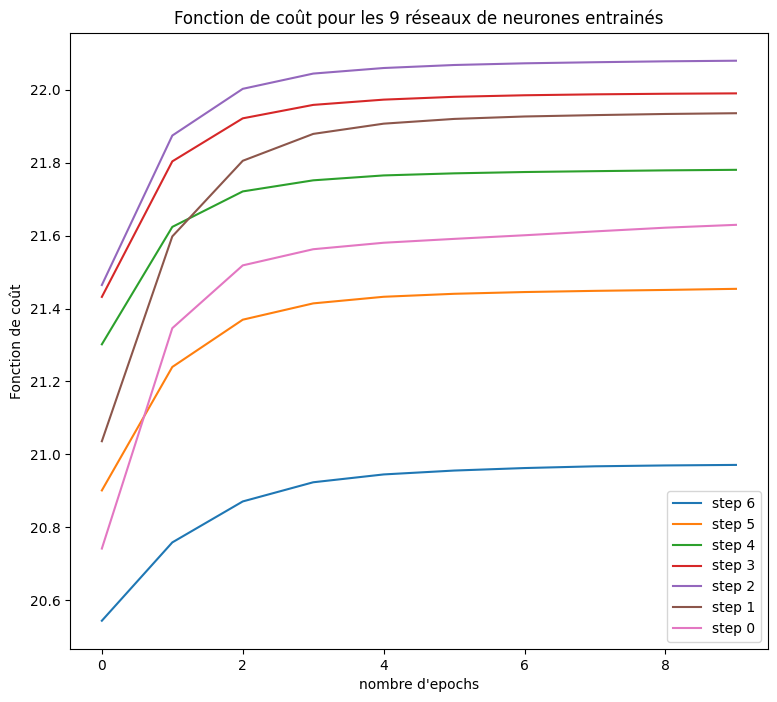

In [53]:
plt.figure(figsize=(9, 8))

history = pricer_dos.intermediate_values["loss"]
for epoch in range(1,len(history)):
    plt.plot(history[epoch],label=f"step {len(history)-1-epoch}")

plt.xlabel("nombre d'epochs")
plt.ylabel("Fonction de coût")
plt.legend()
plt.title("Fonction de coût pour les 9 réseaux de neurones entrainés")

**Remarque** : Le nombre d'epochs est trop faible car dans certains cas, le fonction de
coût ne semble pas avoir atteint son maximum local. J'essaie par la suite d'augmenter ce 
nombre pour voir si cela améliore les résultats.

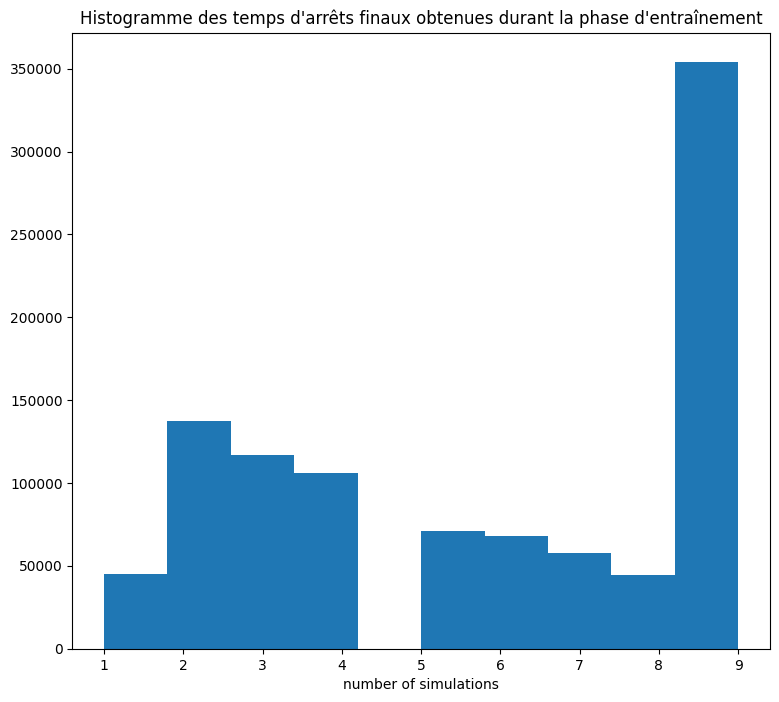

In [54]:
plt.figure(figsize=(9, 8))
plt.hist(stopping_times, bins=10, histtype="barstacked")
plt.xlabel("number of simulations")
plt.title(
    "Histogramme des temps d'arrêts finaux obtenues durant la phase d'entraînement"
)
plt.show()

In [17]:
list_simulation = [i for i in range(1000, 100000, 10000)]
tirage = 20

list_number_simulations = [N for N in range(1000, 100000, 10000)]
list_put_price = np.zeros((tirage, 10))
list_time = np.zeros((tirage, 10))

for idx, n_simulation in tqdm(enumerate(range(1000, 100000, 10000))):
    for m in range(tirage):
        price, _, _, t, _ = pricer_dos.test(10, n_simulation)
        list_put_price[m, idx] = price
        list_time[m, idx] = t

10it [00:30,  3.09s/it]


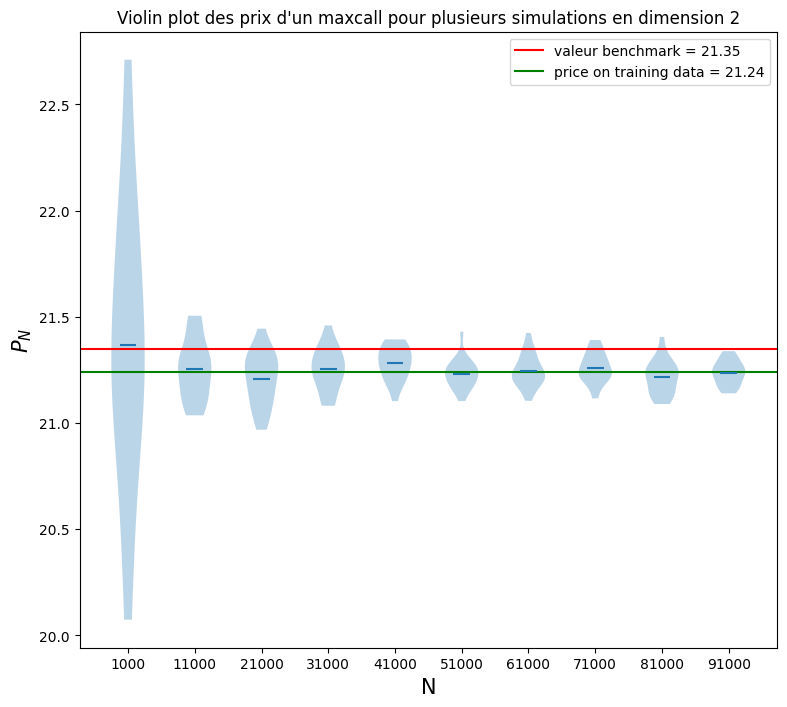

In [18]:
helper_plots.violin_plot(
    list_put_price,
    list_number_simulations,
    21.35,
    "Violin plot des prix d'un maxcall pour plusieurs simulations en dimension 2",
    price_training
)

In [57]:
models = pricer_dos.models
x = np.linspace(40, 200, 100)
y = np.linspace(40, 200, 100)
X, Y = np.meshgrid(x, y)

def get_Z(t):
    # Define the grid
    def f(t,x_1,x_2):
        model = models[t]
        model.eval()
        with torch.no_grad():
            output_model = model(torch.tensor([x_1, x_2]).unsqueeze(0))
            return  1 - output_model


    # Evaluate the function on the grid
    Z = np.zeros_like(X)
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            Z[i, j] = f(t,X[i, j], Y[i, j])

    return Z

In [58]:
def plot_at_t(times):
    num_times = len(times)
    cols = min(num_times, 4)  # Number of columns in subplot grid
    rows = (num_times + cols - 1) // cols  # Compute rows needed for subplots

    plt.figure(figsize=(cols * 5, rows * 5))  # Adjust figure size based on number of subplots

    for i, t in enumerate(times):
        plt.subplot(rows, cols, i + 1)
        Z = get_Z(t=t)
        levels = np.linspace(Z.min(), Z.max(), 100)
        plt.contourf(X, Y, Z, levels=levels, cmap='RdYlBu_r')
        plt.colorbar()
        plt.title(f"Time is {t} / 10")

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show() 

100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


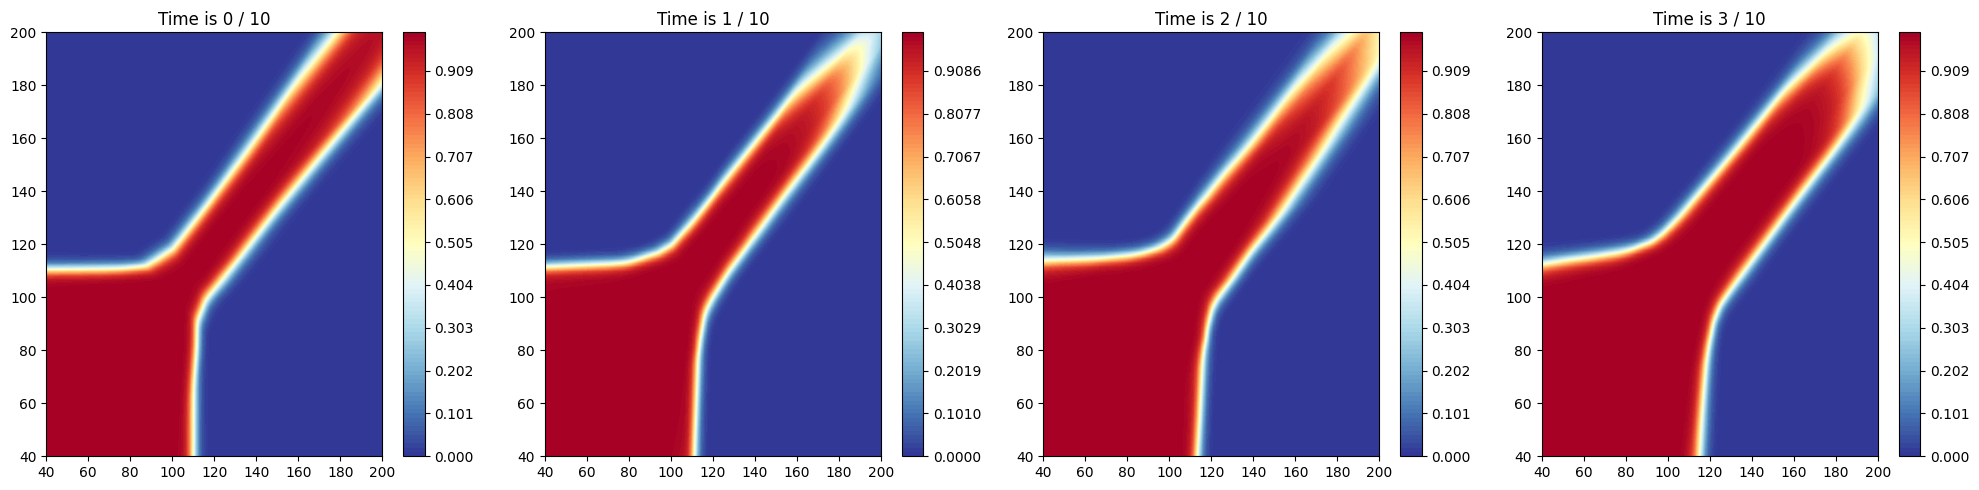

<Figure size 640x480 with 0 Axes>

In [59]:
plot_at_t([0,1,2,3])

100%|██████████| 100/100 [00:01<00:00, 55.43it/s]


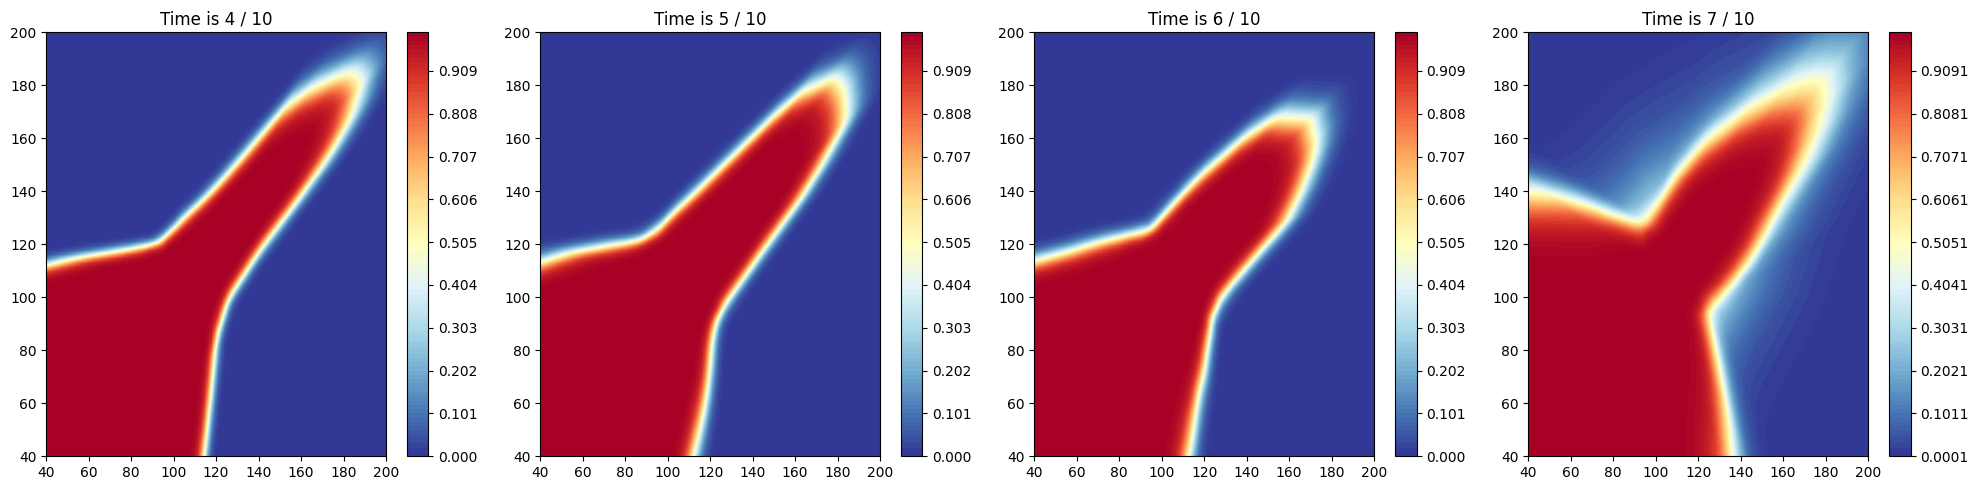

<Figure size 640x480 with 0 Axes>

In [60]:
plot_at_t([4,5,6,7])

### d = 50

In [21]:
d = 20
N_training = int(5e5)
n = 10
earning_rate = 1e-2
batch_size = 10000
epochs = 20
strike = 100
spot = 110
rate = 0.05
vol = 0.2
dividend = 0.10
maturity = 3

def call_payoff(x):
    d = x.shape[1]
    max_mat = np.zeros((x.shape[0], d))
    for i in range(d):
        max_mat[:, i] = np.maximum(np.squeeze(x[:, i]) - strike, 0)
    return np.max(max_mat, axis=1)


o = option.Option(maturity, strike, rate, call_payoff)
asset = [bs.BlackScholes(spot, rate, vol, dividend) for _ in range(d)]

In [22]:
pricer_dos = dos_pricer.PricerDeepOptimalStopping(
    o, asset, list_weights, learning_rate, batch_size, activation_function, epochs
)
price_training,_,_,_,stopping_times = pricer_dos.price(n,N_training,disable=False)

100%|██████████| 8/8 [02:08<00:00, 16.08s/it]


In [23]:
print(f"price on training set is {price_training}")

price on training set is 63.72129499873594


In [24]:
list_simulation = [i for i in range(1000, 100000, 10000)]
tirage = 20

list_number_simulations = [N for N in range(1000, 100000, 10000)]
list_put_price = np.zeros((tirage, 10))
list_time = np.zeros((tirage, 10))

for idx, n_simulation in tqdm(enumerate(range(1000, 100000, 10000))):
    for m in range(tirage):
        price, _, _, t, _ = pricer_dos.test(10, n_simulation)
        list_put_price[m, idx] = price
        list_time[m, idx] = t

10it [03:15, 19.54s/it]


Text(0.5, 1.0, 'Fonction de coût pour les 9 réseaux de neurones entrainés')

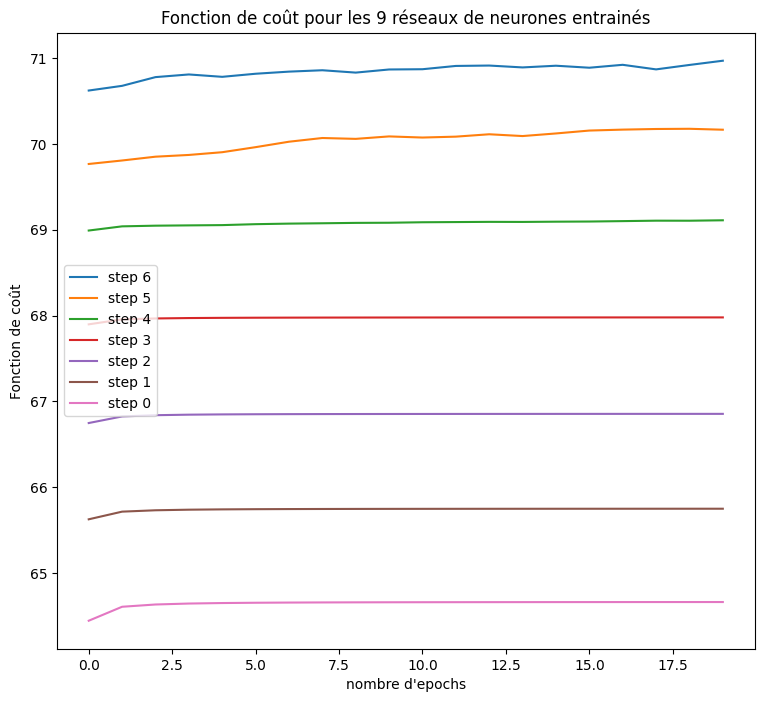

In [25]:
plt.figure(figsize=(9, 8))

history = pricer_dos.intermediate_values["loss"]
for epoch in range(1,len(history)):
    plt.plot(history[epoch],label=f"step {len(history)-1-epoch}")

plt.xlabel("nombre d'epochs")
plt.ylabel("Fonction de coût")
plt.legend()
plt.title("Fonction de coût pour les 9 réseaux de neurones entrainés")

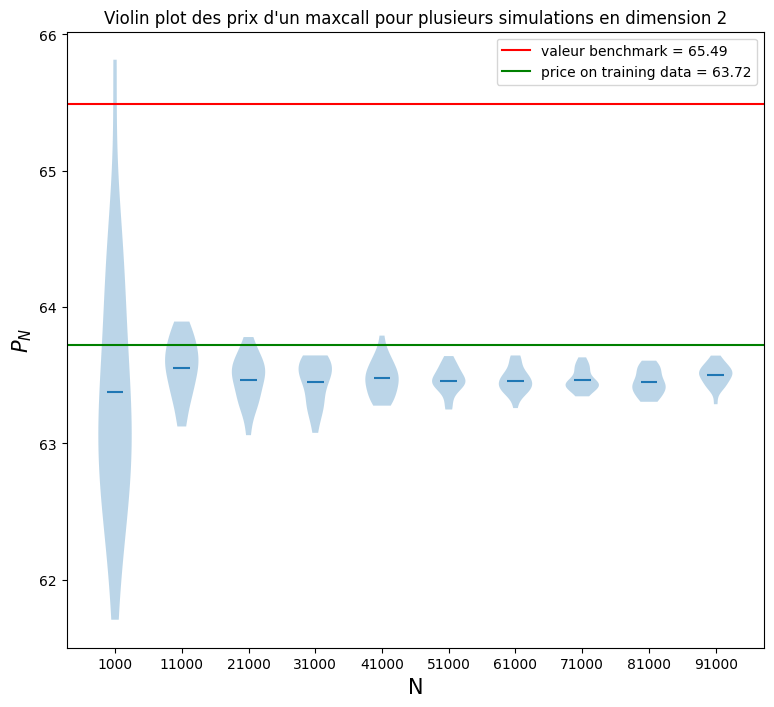

In [26]:
helper_plots.violin_plot(
    list_put_price,
    list_number_simulations,
    65.49,
    "Violin plot des prix d'un maxcall pour plusieurs simulations en dimension 2",
    price_training
)